## Import Library

In [10]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
import scipy
from pathlib import Path

from joblib import dump, load
import pandas as pd

from utils import read_data
from visualization import plot_confusion_matrix

In [11]:
import sys

project_root = Path.cwd().parents[0]
data_path = project_root / 'data'
model_path = project_root / 'model'

src_dir = project_root / 'src'

sys.path.append(str(src_dir))

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
corpus_path = data_path / 'Indonesian_Manually_Tagged_Corpus.tsv'
tagged_sentences = read_data(corpus_path)

In [14]:
print("Number of Tagged Sentences ", len(tagged_sentences))
tagged_words = [tup for sent in tagged_sentences for tup in sent]
print("Total Number of Tagged words", len(tagged_words))
vocab = set([word for word, tag in tagged_words])
print("Vocabulary of the Corpus", len(vocab))
tags = set([tag for word, tag in tagged_words])
print("Number of Tags in the Corpus ", len(tags))

Number of Tagged Sentences  10030
Total Number of Tagged words 256622
Vocabulary of the Corpus 18287
Number of Tags in the Corpus  24


In [15]:
from collections import Counter 

tag_counter = Counter([tag for word, tag in tagged_words])

### Performance Dataframe

In [19]:
import seaborn as sns
import numpy as np

performance_dfs = pd.read_csv(data_path / 'model performance.csv')
data = performance_dfs.query("tags_overall == 'weighted avg'")
model_avg_f1 = data.groupby('model_type')['f1-score'].agg([np.mean, np.std]) * 100
model_avg_f1

,mean,std
model_type,,
crf-baseline,71.726102,0.251751
crf-with-allfix,97.304530,0.093265
crf-with-prefix,95.384298,0.041855
crf-with-suffix,94.197502,0.091220


### Best Model Classification Report and Confusion Matrix

In [20]:
from model import fit_and_dump, prepare_train_test

path = model_path / 'crf-with-allfix-fold01-seed42.joblib'
crf = load(path)
seed = int(str(path).split('.')[0][-2:])
X_train, y_train, X_test, y_test = prepare_train_test(tagged_sentences, seed, path)
train_set, test_set = train_test_split(tagged_sentences, test_size=0.2, random_state=seed)

y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=crf.classes_, digits=3))

C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          IN      0.963     0.968     0.965      4096
          NN      0.970     0.974     0.972     12316
          JJ      0.949     0.948     0.948      1972
          PR      0.997     0.995     0.996      1111
           Z      0.998     0.998     0.998      5211
          CD      0.995     0.993     0.994      3591
         SYM      1.000     0.991     0.995       428
          VB      0.990     0.988     0.989      6371
          CC      0.988     0.979     0.983      1552
          RB      0.977     0.960     0.968      1007
          MD      0.993     0.985     0.989      1054
         PRP      0.997     0.994     0.996      1549
         NNP      0.951     0.964     0.958      6661
          SC      0.949     0.957     0.953      2601
         NND      0.939     0.906     0.922       255
          FW      0.916     0.810     0.860       458
         NEG      0.993     0.997     0.995       287
           X      0.800    

C:\Users\ANTHONI\Documents\kataai\src\visualization.py:20: RuntimeWarning: invalid value encountered in true_divide
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


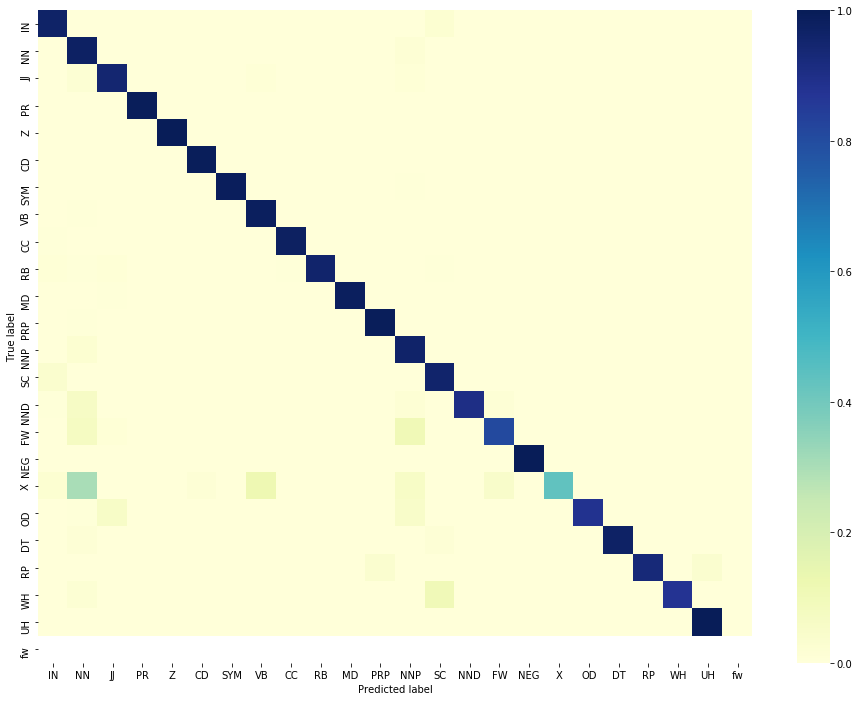

In [21]:
from visualization import plot_confusion_matrix

plot_confusion_matrix(y_test, y_pred, crf.classes_);

### Error analysis initial based on confusion matrix

In [11]:
# get sentence index for every tag
d = []
for index, sentence in enumerate(y_test):
    for tag in sentence:
        d.append((index, tag))

In [150]:
import pandas as pd
from utils import flatten


df = pd.DataFrame(d, columns=['sentence_index', 'y_test'])
df['y_pred'] = flatten(y_pred)
df['word'] = [word for sentence in test_set for word, _ in sentence]

# df[(df.y_test == 'X') & (df.y_pred == 'NN')]
# df[(df.y_test == 'X')]
# df[(df.y_test == 'WH') & (df.y_pred == 'SC')]
# df[(df.y_test == 'WH')].drop_duplicates(subset=['y_test', 'y_pred', 'word'])
# test_set[695]

In [73]:
df[df.word == 'antar']
# test_set[627]

,sentence_index,y_test,y_pred,word
15943,627,IN,IN,antar
46102,1816,IN,IN,antar


In [94]:
from model import prepare_data

In [171]:
from sklearn.metrics import confusion_matrix
def error_analysis(error_set):
    path = model_path / 'crf-with-allfix-fold01-seed42.joblib'
    crf = load(path)
    X_test, y_test = prepare_data(error_set, prefix=True, suffix=True)
    y_pred = crf.predict(X_test)
    words = [word for sent in error_set for word, _ in sent]
    return pd.DataFrame({'words': words, 'true label': y_test[0], 'predict label': y_pred[0]})

In [172]:
error_1 = [[('Nilai', 'NN'),
  ('tukar', 'VB'),
  ('rupiah', 'NN'),
  ('terhadap', 'IN'),
  ('dolar', 'NN'),
  ('AS', 'NNP'),
  ('di', 'IN'),
  ('pasar', 'NN'),
  ('spot', 'NNP'),
  ('antarnegara', 'X'),
  (',', 'Z'),
  ('Senin', 'NNP'),
  ('sore', 'NN'),
  ('melemah', 'VB'),
  ('lima', 'CD'),
  ('poin', 'NN')]]

In [173]:
error_analysis(error_1)

,predict label,true label,words
0,NN,NN,Nilai
1,VB,VB,tukar
2,NN,NN,rupiah
3,IN,IN,terhadap
4,NN,NN,dolar
5,NNP,NNP,AS
6,IN,IN,di
7,NN,NN,pasar
8,NNP,NNP,spot
9,NN,X,antarnegara


In [46]:
def feature_ablation(d, entriesToRemove = None):
    for k in entriesToRemove:
        d.pop(k, None)
    return d
      
def features(sentence, index, entriesToRemove = None):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    ### and entriestoRemove type is tuple
    d = {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index == 0),
        'is_last_word':int(index == len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
        'prev_word':'' if index == 0 else sentence[index-1],
        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
         }
    
    if not entriesToRemove:
        return d
    else:
        return feature_ablation(d, entriesToRemove)
                
def untag(sentence):
      return [word for word, tag in sentence]


def prepareData(tagged_sentences, entriesToRemove):
    X, y = [], []
    for sentences in tagged_sentences:
        X.append([features(untag(sentences), index, entriesToRemove) for index in range(len(sentences))])
        y.append([tag for word, tag in sentences])
    return X, y

suffix_removed = tuple(['suffix_1', 'suffix_2', 'suffix_3', 'suffix_4'])
prefix_removed = tuple(['prefix_1', 'prefix_2', 'prefix_3', 'prefix_4'])
anyfix_removed = tuple(['prefix_1', 'prefix_2', 'prefix_3', 'prefix_4', 'suffix_1', 'suffix_2', 'suffix_3', 'suffix_4'])
X_train, y_train = prepareData(train_set, anyfix_removed)
X_test, y_test = prepareData(test_set, anyfix_removed)